In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym 
import random
import os
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import VecFrameStack
from stable_baselines3.common.evaluation import evaluate_policy
from gym import Env
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete 
from scipy.optimize import minimize

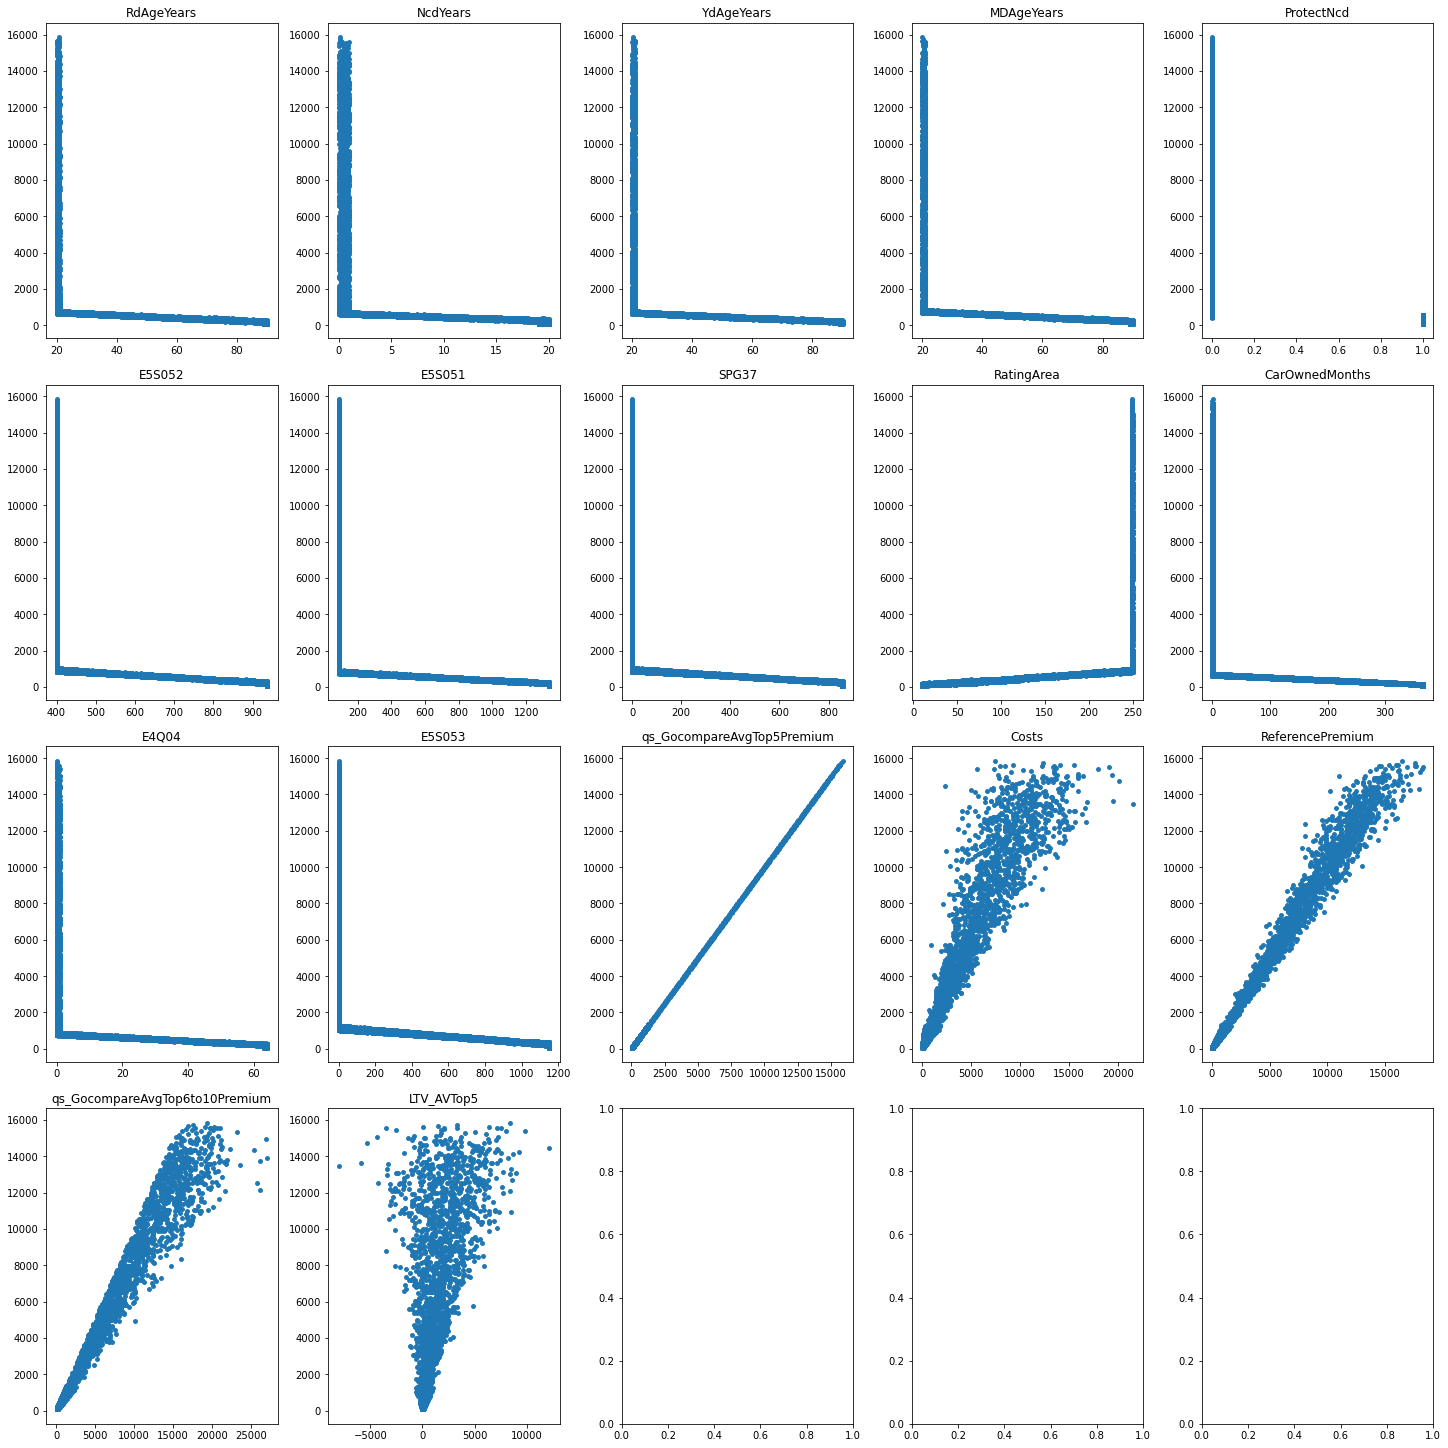

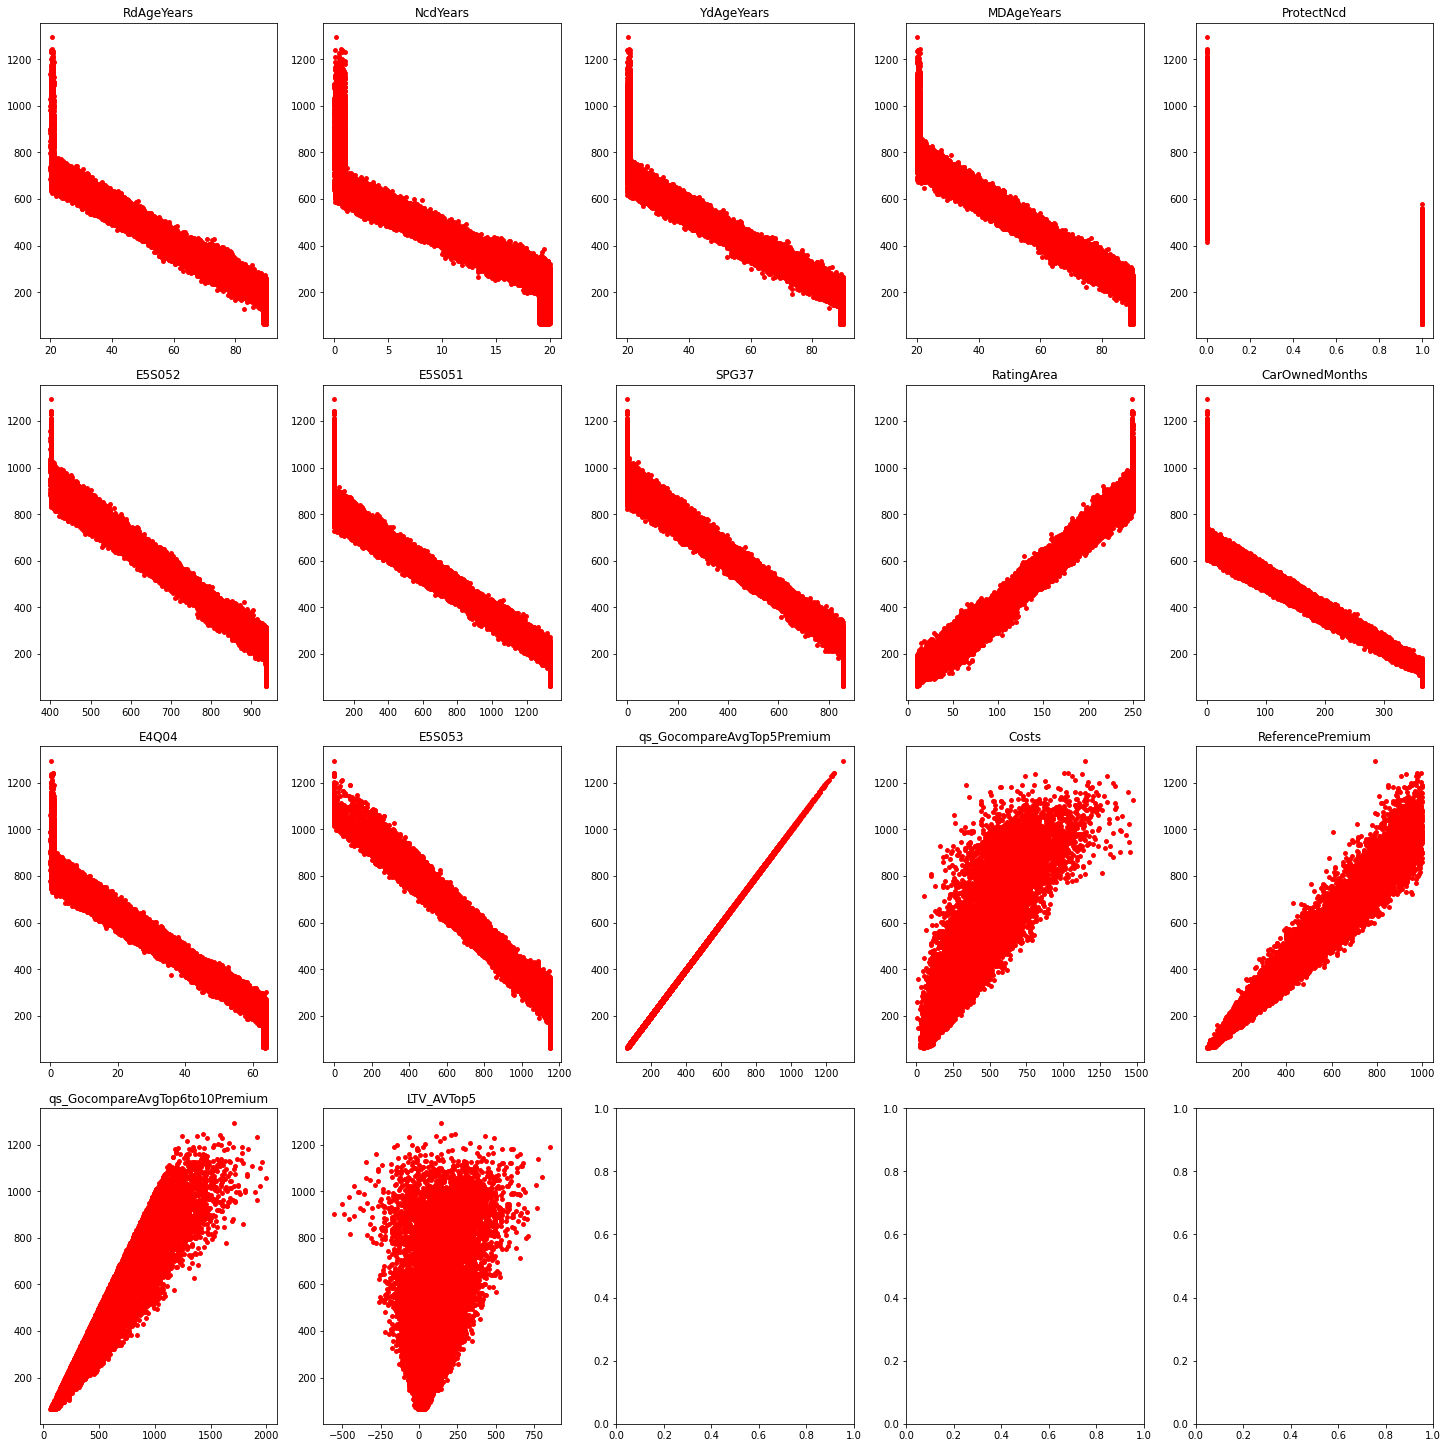

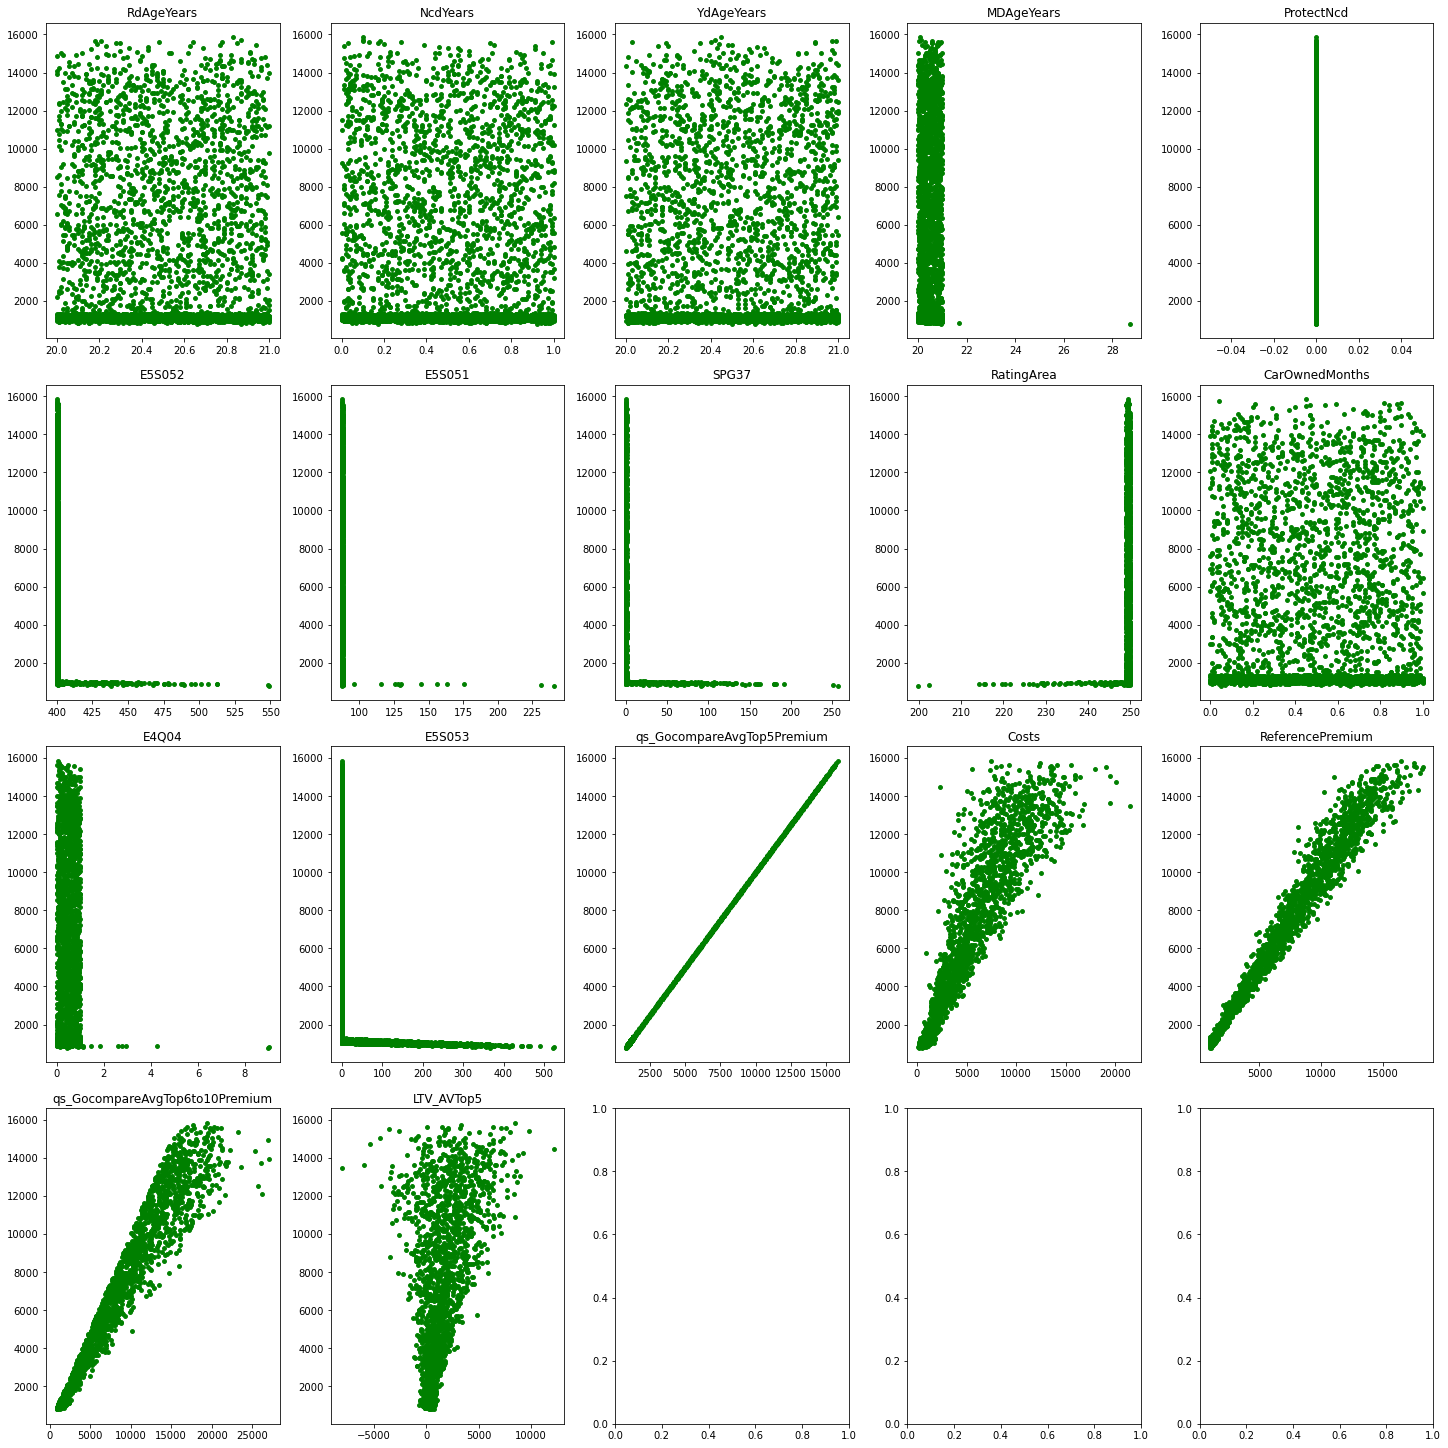

In [2]:
Load_Data = pd.read_csv('customer_data_v3.csv')
Load_Data['Costs'] = Load_Data['qs_GocompareAvgTop5Premium']*(0.8 + np.random.normal(0, 0.2, len(Load_Data['qs_GocompareAvgTop5Premium'])))
Load_Data['ProtectNcd'] = Load_Data['ProtectNcd'].astype(int)
Load_Data['ReferencePremium'] = Load_Data['qs_GocompareAvgTop5Premium']*(1 + np.random.normal(0, 0.1, len(Load_Data['qs_GocompareAvgTop5Premium'])))
Load_Data['qs_GocompareAvgTop6to10Premium'] = Load_Data['qs_GocompareAvgTop5Premium']*(1 + np.abs(np.random.normal(0, 0.3, len(Load_Data['qs_GocompareAvgTop5Premium']))))
Load_Data['LTV_AVTop5'] = Load_Data['qs_GocompareAvgTop5Premium'] - Load_Data['Costs']
Data_feature = Load_Data.columns
k=0
fig, axs = plt.subplots(4, 5, figsize=(20, 20), constrained_layout=True)
for a in Data_feature:
    axs[int(k/5),k%5].scatter(Load_Data[a],Load_Data['qs_GocompareAvgTop5Premium'], s=15)
    axs[int(k/5),k%5].set_title(a)
    k=k+1
    
Esure_range_data = Load_Data[(Load_Data['ReferencePremium']<1000)]
Esure_out_range_data = Load_Data[Load_Data['ReferencePremium']>1000]


k=0
fig, axs = plt.subplots(4, 5, figsize=(20, 20), constrained_layout=True)
for a in Data_feature:
    axs[int(k/5),k%5].scatter(Esure_range_data[a],Esure_range_data['qs_GocompareAvgTop5Premium'], s=15, color = 'red')
    axs[int(k/5),k%5].set_title(a)
    k=k+1
                                  
k=0
fig, axs = plt.subplots(4, 5, figsize=(20, 20), constrained_layout=True)
for a in Data_feature:
    axs[int(k/5),k%5].scatter(Esure_out_range_data[a],Esure_out_range_data['qs_GocompareAvgTop5Premium'], s=15, color = 'green')
    axs[int(k/5),k%5].set_title(a)
    k=k+1

In [3]:
Check = 1.3*Load_Data['ReferencePremium']-Load_Data['Costs']
print(sum(Check<0)/len(Check))

0.019


In [4]:
Data = Load_Data
No_data = len(Data)
print(No_data)
Training_label = np.random.choice(range(No_data), size=int(No_data*0.8), replace=False)
Test_label = list(set(range(No_data)) - set(Training_label))
Training_data = Data.iloc[Training_label]
Testing_data = Data.iloc[Test_label]
print(len(Testing_data))

35000
7000


Propose the demand curve for the model

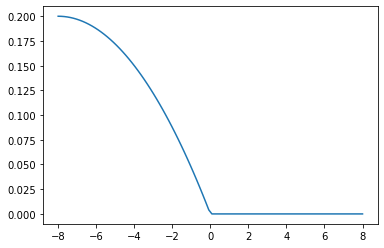

In [5]:
gamma = 2
def demand(Regressor):
    demand_curve1 = -0.2*np.abs(Regressor/8+1)**gamma+0.2
    demand_curve = np.maximum(demand_curve1,0)
    demand_curve = demand_curve*(Regressor>-8) + 0.2*(Regressor<=-8)
    
    return demand_curve
plt.plot(np.linspace(-8, 8,100), demand(np.linspace(-8, 8,100)))
    

Assume that the data follows the logistic model with regressor corresponding to the difference between the proposed price and average top 5 premium divided by the spread of the market given by average top 5 premium-average top 10 premium

In [6]:
def Feedback_Generator(No_sample, Data):
    Generated_data = Data.sample(n=No_sample, replace=True)
    Generated_data['QuotedPrice'] = Generated_data['qs_GocompareAvgTop5Premium']*(1 + np.random.normal(0, 0.3, len(Generated_data['qs_GocompareAvgTop5Premium'])))
    Regressor = (Generated_data['QuotedPrice']-Generated_data['qs_GocompareAvgTop5Premium'])/(Generated_data['qs_GocompareAvgTop6to10Premium']-Generated_data['qs_GocompareAvgTop5Premium'])
    Prob_decision = demand(Regressor)
    Generated_data['Customer_Decision'] = np.random.binomial(1,Prob_decision)
    return Generated_data

Generate synthetic feedback

In [7]:
Generated_data = Feedback_Generator(5*10**6, Training_data)
print(Generated_data['Customer_Decision'].mean())

0.0345


In [8]:
Generated_data['Position'] = (Generated_data['QuotedPrice']-Generated_data['qs_GocompareAvgTop5Premium'])/(Generated_data['qs_GocompareAvgTop5Premium']-Generated_data['qs_GocompareAvgTop6to10Premium'])
Generated_data['Position'] = ((100*Generated_data['Position']).astype(int))/100
print(Generated_data['Position'])

10967    -0.58
10494   -29.72
10912     1.88
804      -1.87
4188      0.12
         ...  
34544    -2.06
28716     0.86
8339      0.75
24674    -1.51
4909      0.32
Name: Position, Length: 5000000, dtype: float64


In [9]:
Action_gap = 0.003
Action_space_size = 100

In [10]:
class Price_Env_Exp_reward(Env):
    def __init__(self, Available_data):
        # Record available data for the environment
        self.Data = Available_data
        self.action_space = Discrete(2*Action_space_size)
        # State corresponds to the information available from the customer
        
        self.observation_space = Dict({'RdAgeYears':Box(min(Data['RdAgeYears']),max(Data['RdAgeYears']), shape=(1,)),
              'NcdYears':Box(min(Data['NcdYears']),max(Data['NcdYears']), shape=(1,)),
              'YdAgeYears':Box(min(Data['YdAgeYears']),max(Data['YdAgeYears']), shape=(1,)),                         
              'MDAgeYears':Box(min(Data['MDAgeYears']),max(Data['MDAgeYears']), shape=(1,)),
              'ProtectNcd':Discrete(2),
              'E5S052':Box(min(Data['E5S052']),max(Data['E5S052']), shape=(1,)),
              'E5S051':Box(min(Data['E5S051']),max(Data['E5S051']), shape=(1,)),
              'SPG37':Box(min(Data['SPG37']),max(Data['SPG37']), shape=(1,)),
              'RatingArea':Box(min(Data['RatingArea']),max(Data['RatingArea']), shape=(1,)),
              'CarOwnedMonths':Box(min(Data['CarOwnedMonths']),max(Data['CarOwnedMonths']), shape=(1,)),
              'E4Q04':Box(min(Data['E4Q04']),max(Data['E4Q04']), shape=(1,)),
              'E5S053':Box(min(Data['E5S053']),max(Data['E5S053']), shape=(1,)),
              'Costs':Box(min(Data['Costs']),max(Data['Costs']), shape=(1,)),
              'ReferencePremium':Box(min(Data['ReferencePremium']),max(Data['ReferencePremium']), shape=(1,)),
             })
        
        # The factor in the state space
        self.factors = self.observation_space.sample().keys()
        
        
        # Set the customer property
        self.customer = self.Data.sample()
        self.state = self.customer[self.factors]
        
        
        self.Data['Position'] = (self.Data['QuotedPrice']-self.Data['qs_GocompareAvgTop5Premium'])/(self.Data['qs_GocompareAvgTop6to10Premium']-self.Data['qs_GocompareAvgTop5Premium'])
        self.Data['Position'] = ((100*self.Data['Position']).astype(int))/100
        Conversion_prob = dict()
        for b in np.arange(-700,700):
            a = b/100
            Focus_data = self.Data[self.Data['Position']==a]
            No_quote = len(Focus_data['Customer_Decision'])
            Accepted_quote = Focus_data['Customer_Decision'].sum()
            Conversion_prob[a] = Accepted_quote/(10**(-6) + No_quote)
        # We add 10**(-6) to ensure that the denominator is positive.
        plt.plot(Conversion_prob.keys(),Conversion_prob.values())

        MA_length = 100
        Conversion_prob_MA = dict()
        mean = 1
        for b in range(-700, 700-MA_length):
            mean_prev = mean
            a = (b+MA_length/2)/100
            key = np.arange(b, b+MA_length)/100
            values = list(map(Conversion_prob.get,key))
            mean = np.minimum(np.mean(values), mean_prev)
            Conversion_prob_MA[a] = mean
        plt.plot(Conversion_prob_MA.keys(),Conversion_prob_MA.values())
        self.Conversion_prob_MA = Conversion_prob_MA
        self.max_position = max(Conversion_prob_MA.keys())
        self.min_position = min(Conversion_prob_MA.keys())

    
    def Price(self, Action):
        return np.array((1+ (Action-Action_space_size)*Action_gap)*self.customer['ReferencePremium'])[0]
    
    def Customer_Decision(self, Customer_Entry, Proposed_Price):
        Position = (Proposed_Price - Customer_Entry['qs_GocompareAvgTop5Premium'])/(Customer_Entry['qs_GocompareAvgTop6to10Premium']-Customer_Entry['qs_GocompareAvgTop5Premium'])
        Int_position = int(100*Position)/100
        Int_position = min(Int_position, self.max_position)
        Int_position = max(Int_position, self.min_position)
        Conv_prob_customer = self.Conversion_prob_MA[Int_position]
        return Conv_prob_customer
        
    def step(self, Action):
        #Identify customer decision
        Proposed_price = self.Price(Action)
        Prob = self.Customer_Decision(self.customer, Proposed_price)
        #Identify our reward
        reward = np.array(Prob*(Proposed_price-self.customer['Costs']))[0]
        #We only need to make the decision for a single step
        done = True
        # Set placeholder for info
        info = {}
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset the system to get the new customer
        self.customer = self.Data.sample()
        self.state = self.customer[self.factors]
        return dict(self.state)

Set up environment for training hybrid model

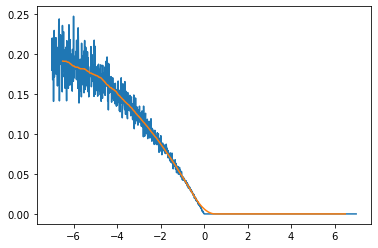

In [11]:
Train_env_hybrid = Price_Env_Exp_reward(Generated_data)

Inspect the expected reward under true model and under our estimated model

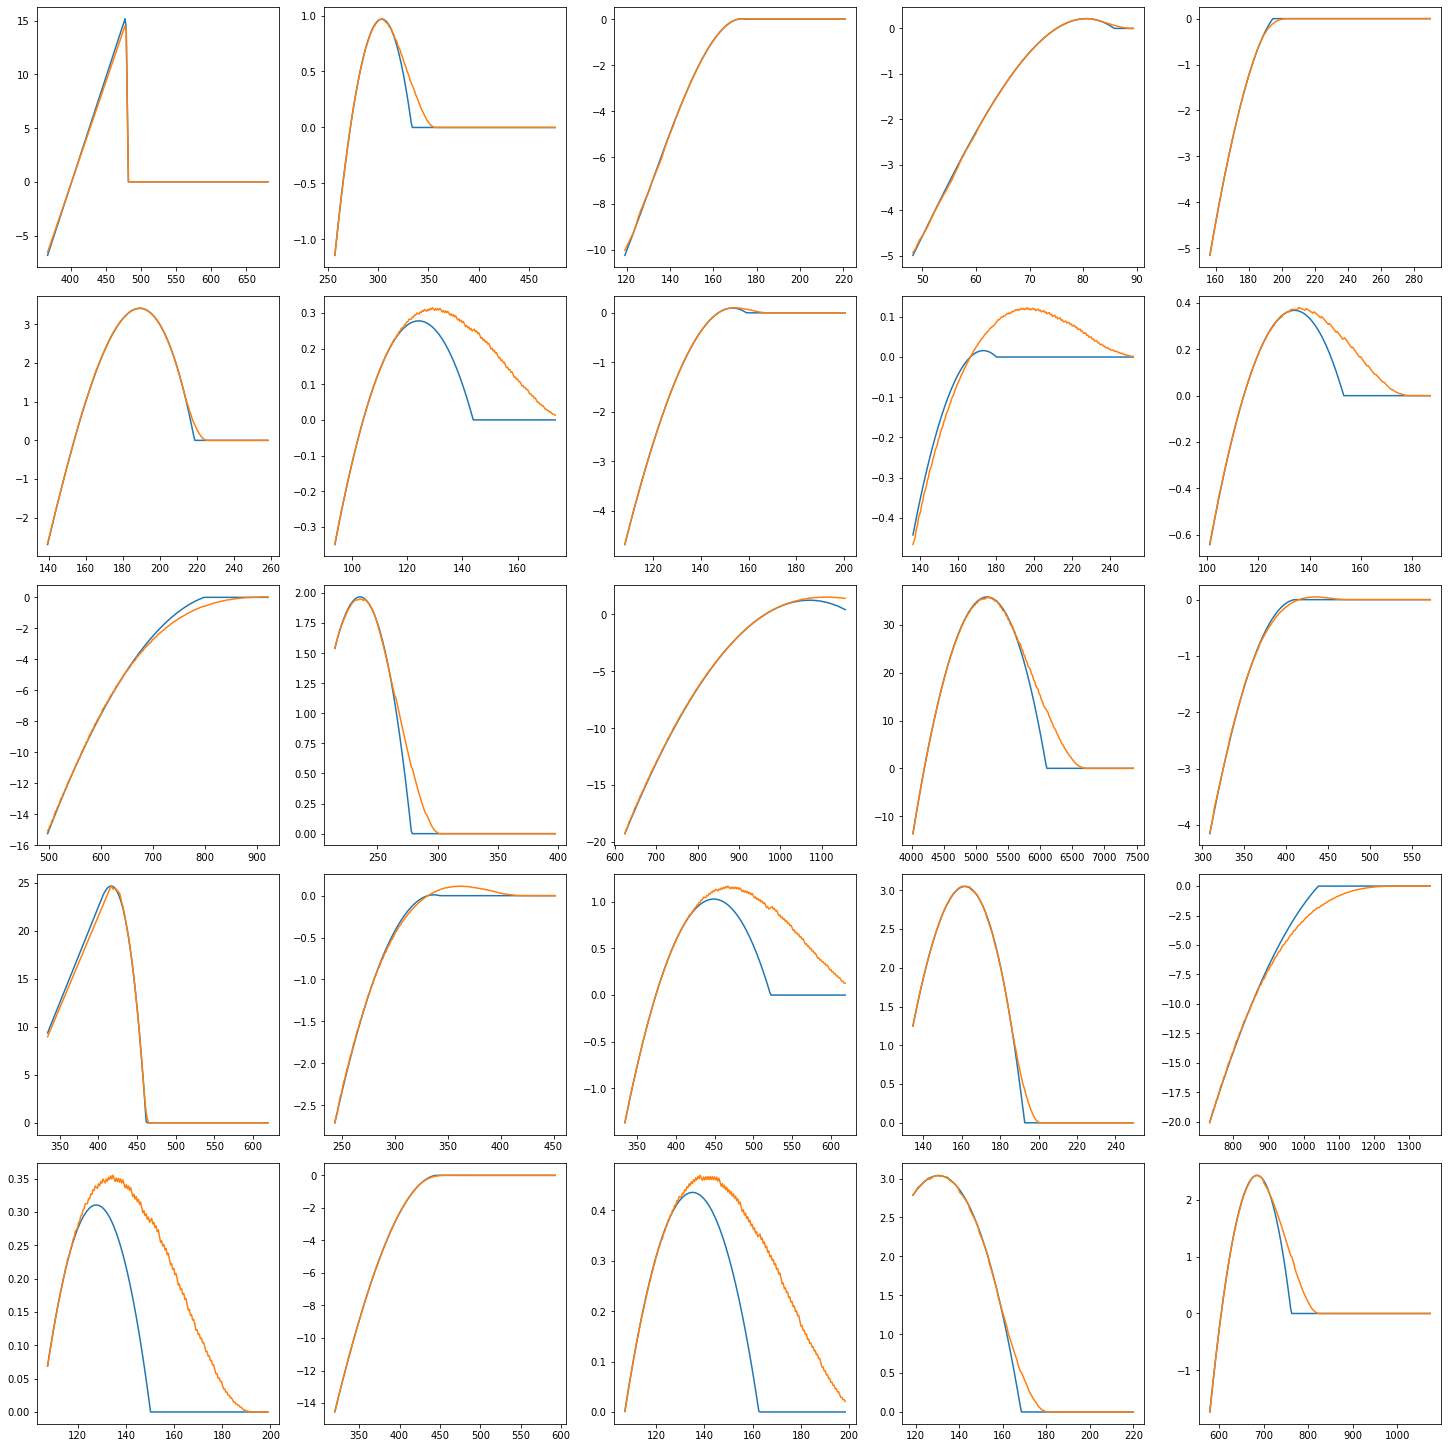

In [12]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20), constrained_layout=True)
for k in range(25):
    state = Train_env_hybrid.reset()
    Customer_Entry =Train_env_hybrid.customer
    Price = (1+ np.arange(-Action_space_size,Action_space_size)*Action_gap)*np.array(Customer_Entry['ReferencePremium'])
    Top5 = np.array(Customer_Entry['qs_GocompareAvgTop5Premium'])[0]
    Top6to10 = np.array(Customer_Entry['qs_GocompareAvgTop6to10Premium'])[0]
    Regressor =  (Price - Top5)/(Top6to10-Top5)
    Prob_cal = demand(Regressor)
    Reward = Prob_cal*(Price-np.array(Customer_Entry['Costs']))
    axs[int(k/5),k%5].plot(Price, Reward)
    
    Reward_Est = dict()
    for p in Price:
        Prob = Train_env_hybrid.Customer_Decision(Customer_Entry, p)
        Reward_Est[p] = Prob*(p-np.array(Customer_Entry['Costs']))
    axs[int(k/5),k%5].plot(Reward_Est.keys(), Reward_Est.values())
    
plt.savefig('reward_comparison.pdf')

In [13]:
log_path = os.path.join('Training', 'Logs')
#We identify our model and method for training.
model = A2C("MultiInputPolicy", Train_env_hybrid, verbose=1)
#run the training.
model.learn(total_timesteps=2*10**4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 5.63     |
| time/                 |          |
|    fps                | 5        |
|    iterations         | 100      |
|    time_elapsed       | 85       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.28    |
|    explained_variance | 0.199    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 4.83     |
|    value_loss         | 3.52     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 2.99     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 1.1      |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 1400     |
|    time_elapsed       | 1036     |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -2.13    |
|    explained_variance | 0.973    |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | 2.22     |
|    value_loss         | 1.52     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -0.979   |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 1500     |
|    time_elapsed       | 1109     |
|    total_timesteps    | 7500     |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 1.12     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 2800     |
|    time_elapsed       | 2033     |
|    total_timesteps    | 14000    |
| train/                |          |
|    entropy_loss       | -0.251   |
|    explained_variance | 0.447    |
|    learning_rate      | 0.0007   |
|    n_updates          | 2799     |
|    policy_loss        | 0.0176   |
|    value_loss         | 44.5     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 2.18     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 2900     |
|    time_elapsed       | 2107     |
|    total_timesteps    | 14500    |
| train/                |          |
|

In [14]:
class Price_Env_Actual_reward(Env):
    def __init__(self, Available_data):
        # Record available data for the environment
        self.Data = Available_data
        self.action_space = Discrete(2*Action_space_size)
        # State corresponds to the information available from the customer
        
        self.observation_space = Dict({'RdAgeYears':Box(min(Data['RdAgeYears']),max(Data['RdAgeYears']), shape=(1,)),
              'NcdYears':Box(min(Data['NcdYears']),max(Data['NcdYears']), shape=(1,)),
              'YdAgeYears':Box(min(Data['YdAgeYears']),max(Data['YdAgeYears']), shape=(1,)),                         
              'MDAgeYears':Box(min(Data['MDAgeYears']),max(Data['MDAgeYears']), shape=(1,)),
              'ProtectNcd':Discrete(2),
              'E5S052':Box(min(Data['E5S052']),max(Data['E5S052']), shape=(1,)),
              'E5S051':Box(min(Data['E5S051']),max(Data['E5S051']), shape=(1,)),
              'SPG37':Box(min(Data['SPG37']),max(Data['SPG37']), shape=(1,)),
              'RatingArea':Box(min(Data['RatingArea']),max(Data['RatingArea']), shape=(1,)),
              'CarOwnedMonths':Box(min(Data['CarOwnedMonths']),max(Data['CarOwnedMonths']), shape=(1,)),
              'E4Q04':Box(min(Data['E4Q04']),max(Data['E4Q04']), shape=(1,)),
              'E5S053':Box(min(Data['E5S053']),max(Data['E5S053']), shape=(1,)),
              'Costs':Box(min(Data['Costs']),max(Data['Costs']), shape=(1,)),
              'ReferencePremium':Box(min(Data['ReferencePremium']),max(Data['ReferencePremium']), shape=(1,)),
             })
        
        # The factor in the state space
        self.factors = self.observation_space.sample().keys()
        
        
        # Set the customer property
        self.customer = self.Data.sample()
        self.state = self.customer[self.factors]
        
        
        self.Data['Position'] = (self.Data['QuotedPrice']-self.Data['qs_GocompareAvgTop5Premium'])/(self.Data['qs_GocompareAvgTop6to10Premium']-self.Data['qs_GocompareAvgTop5Premium'])
        self.Data['Position'] = ((100*self.Data['Position']).astype(int))/100
        Conversion_prob = dict()
        for b in np.arange(-700,700):
            a = b/100
            Focus_data = self.Data[self.Data['Position']==a]
            No_quote = len(Focus_data['Customer_Decision'])
            Accepted_quote = Focus_data['Customer_Decision'].sum()
            Conversion_prob[a] = Accepted_quote/(10**(-6) + No_quote)
        # We add 10**(-6) to ensure that the denominator is positive.
        plt.plot(Conversion_prob.keys(),Conversion_prob.values())

        MA_length = 100
        Conversion_prob_MA = dict()
        mean = 1
        for b in range(-700, 700-MA_length):
            mean_prev = mean
            a = (b+MA_length/2)/100
            key = np.arange(b, b+MA_length)/100
            values = list(map(Conversion_prob.get,key))
            mean = np.minimum(np.mean(values), mean_prev)
            Conversion_prob_MA[a] = mean
        plt.plot(Conversion_prob_MA.keys(),Conversion_prob_MA.values())
        self.Conversion_prob_MA = Conversion_prob_MA
        self.max_position = max(Conversion_prob_MA.keys())
        self.min_position = min(Conversion_prob_MA.keys())
        plt.savefig('Est_demand.pdf')

    
    def Price(self, Action):
        return np.array((1+ (Action-Action_space_size)*Action_gap)*self.customer['ReferencePremium'])[0]
    
    def Customer_Decision(self, Customer_Entry, Proposed_Price):
        Position = (Proposed_Price - Customer_Entry['qs_GocompareAvgTop5Premium'])/(Customer_Entry['qs_GocompareAvgTop6to10Premium']-Customer_Entry['qs_GocompareAvgTop5Premium'])
        Int_position = int(100*Position)/100
        Int_position = min(Int_position, self.max_position)
        Int_position = max(Int_position, self.min_position)
        Conv_prob_customer = self.Conversion_prob_MA[Int_position]
        return Conv_prob_customer
        
    def step(self, Action):
        #Identify customer decision
        Proposed_price = self.Price(Action)
        Prob = self.Customer_Decision(self.customer, Proposed_price)
        #Identify our reward
        Decision = np.random.binomial(1,Prob)
        reward = np.array(Decision*(Proposed_price-self.customer['Costs']))[0]
        #We only need to make the decision for a single step
        done = True
        # Set placeholder for info
        info = {}
        return self.state, reward, done, info

    def render(self):
        # Implement viz
        pass
    
    def reset(self):
        # Reset the system to get the new customer
        self.customer = self.Data.sample()
        self.state = self.customer[self.factors]
        return dict(self.state)

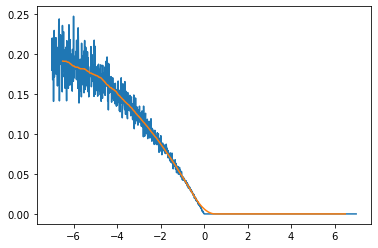

In [15]:
Train_env_standard = Price_Env_Actual_reward(Generated_data)

In [16]:
log_path = os.path.join('Training_actual', 'Logs')
#We identify our model and method for training.
model_std_RL = A2C("MultiInputPolicy", Train_env_standard, verbose=1) #, tensorboard_log=log_path)
#run the training.
model_std_RL.learn(total_timesteps=2*10**4)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.0443   |
| time/                 |          |
|    fps                | 7        |
|    iterations         | 100      |
|    time_elapsed       | 71       |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -5.28    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 0.464    |
|    value_loss         | 0.008    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -1.96    |
| time/                 |          |
|    fps                | 7        |
|    iterations         | 200      |
|    time_elapsed 

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.555    |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 1400     |
|    time_elapsed       | 1001     |
|    total_timesteps    | 7000     |
| train/                |          |
|    entropy_loss       | -4.85    |
|    explained_variance | -0.00134 |
|    learning_rate      | 0.0007   |
|    n_updates          | 1399     |
|    policy_loss        | -17.7    |
|    value_loss         | 52.9     |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 1.66     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 1500     |
|    time_elapsed       | 1072     |
|    total_timesteps    | 7500     |
| train/                |          |
|

------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 2.69     |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 2700     |
|    time_elapsed       | 1929     |
|    total_timesteps    | 13500    |
| train/                |          |
|    entropy_loss       | -4.19    |
|    explained_variance | nan      |
|    learning_rate      | 0.0007   |
|    n_updates          | 2699     |
|    policy_loss        | -0.277   |
|    value_loss         | 0.0025   |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | -5.29    |
| time/                 |          |
|    fps                | 6        |
|    iterations         | 2800     |
|    time_elapsed       | 2000     |
|    total_timesteps    | 14000    |
| train/                |          |
|

In [17]:
def Model_based_Optimisation(Train_env, Customer_Entry, Est_top5, Est_top6to10):
    Price = (1+ (np.arange(-Action_space_size, Action_space_size))*Action_gap)*np.array(Customer_Entry['ReferencePremium'])[0]
    Position = (Price - Est_top5)/(Est_top5-Est_top6to10)
    Int_position = (100*Position).astype(int)/100
    Int_position = np.minimum(Int_position, Train_env.max_position)
    Int_position = np.maximum(Int_position, Train_env.min_position)
    Conv_prob_customer = list( map(Train_env.Conversion_prob_MA.get, Int_position) )
    Reward_size = Price - np.array(Customer_Entry['Costs'])
    Exp_reward = Reward_size*Conv_prob_customer
    Maximum_index = np.argmax(Exp_reward)
    Chosen_Price = Price[Maximum_index]
    return Chosen_Price
    

In [18]:
def Best_decision(Customer_Entry):
    Price = (1+ (np.arange(-Action_space_size, Action_space_size))*Action_gap)*np.array(Customer_Entry['ReferencePremium'])[0]
    Top5 = np.array(Customer_Entry['qs_GocompareAvgTop5Premium'])[0]
    Top6to10 = np.array(Customer_Entry['qs_GocompareAvgTop6to10Premium'])[0]
    Regressor =  (Price - Top5)/(Top6to10-Top5)
    Prob_cal = demand(Regressor)
    Exp_reward = Prob_cal*(Price-np.array(Customer_Entry['Costs']))
    Maximum_index = np.argmax(Exp_reward)
    Chosen_Price = Price[Maximum_index]
    return Chosen_Price
    

In [19]:
def True_decision(Customer_Entry, Price):
    Top5 = np.array(Customer_Entry['qs_GocompareAvgTop5Premium'])[0]
    Top6to10 = np.array(Customer_Entry['qs_GocompareAvgTop6to10Premium'])[0]
    Regressor =  (Price - Top5)/(Top6to10-Top5)
    Prob_cal = demand(Regressor)
    return Prob_cal
    
    

In [20]:
def Run_Experiment(Number_of_customers, Train_env):
    Reward_record = dict()
    Exp_Reward_record = dict()
    Price_record = dict()
    for a in ["Random", "Model_based", "Model_based_under_est", "Model_based_over_est","Std_RL", "Hybrid_RL","Perfect_Info"]:
        Reward_record[a] = np.zeros(Number_of_customers)
        Exp_Reward_record[a] = np.zeros(Number_of_customers)
        Price_record[a] = np.zeros(Number_of_customers)
    
    for e in range(1, Number_of_customers+1):
        state = Train_env.reset()
        
        Price = dict()
        Prob = dict()
        Reward_size = dict()
        Decision = dict()
        
        Action_random = Train_env.action_space.sample()
        Price["Random"] = Train_env.Price(Action_random)
        
        Est_top5 = np.array(Train_env.customer['qs_GocompareAvgTop5Premium']*(1+np.random.normal(0,0.3)))[0]
        Est_top6to10 = np.array(Train_env.customer['qs_GocompareAvgTop6to10Premium']*(1+np.random.normal(0,0.3)))[0]
        Price["Model_based"] = Model_based_Optimisation(Train_env, Train_env.customer, Est_top5, Est_top6to10)
        
        Est_top5_under = np.array(Train_env.customer['qs_GocompareAvgTop5Premium']*(0.8+np.random.normal(0,0.3)))[0]
        Est_top6to10_under = np.array(Train_env.customer['qs_GocompareAvgTop6to10Premium']*(0.8+np.random.normal(0,0.3)))[0]
        Price["Model_based_under_est"] = Model_based_Optimisation(Train_env, Train_env.customer, Est_top5_under, Est_top6to10_under)
        
        Est_top5_over = np.array(Train_env.customer['qs_GocompareAvgTop5Premium']*(1.2+np.random.normal(0,0.3)))[0]
        Est_top6to10_over = np.array(Train_env.customer['qs_GocompareAvgTop6to10Premium']*(1.2+np.random.normal(0,0.3)))[0]
        Price["Model_based_over_est"] = Model_based_Optimisation(Train_env, Train_env.customer, Est_top5_over, Est_top6to10_over)
        
        Action_std_RL, _ = model_std_RL.predict(dict(state))
        Price["Std_RL"] = Train_env.Price(Action_std_RL)
        
        Action_Hybrid_RL, _ = model.predict(dict(state))
        Price["Hybrid_RL"] = Train_env.Price(Action_Hybrid_RL)
        
        Price["Perfect_Info"] = Best_decision(Train_env.customer)
        
        U = np.random.uniform()
        
        for a in Price.keys():
            Prob[a] = True_decision(Train_env.customer, Price[a])
            Decision[a] = int(U<Prob[a])
            Reward_size[a] = np.array(Price[a]-Train_env.customer['Costs'])[0]
            
            Reward_record[a][e-1] = Decision[a]*Reward_size[a]
            Exp_Reward_record[a][e-1] = Prob[a]*Reward_size[a]
            Price_record[a][e-1] = Price[a]
    
    for a in Price.keys():
        Conversion_customer = (Reward_record[a]!=0).mean()
        Conversion_customer_profit = (Reward_record[a]>0).mean()
        av_reward = Reward_record[a].mean()
        av_Exp_reward = Exp_Reward_record[a].mean()
        Over_price_proportion = (Price_record[a]>Price_record["Perfect_Info"]).mean()
        Under_price_proportion = (Price_record[a]<Price_record["Perfect_Info"]).mean()
        Sub_opt_price = (np.abs(Price_record[a]-Price_record["Perfect_Info"])).mean()
        Av_over_price = (np.abs(Price_record[a]-Price_record["Perfect_Info"])*(Price_record[a]>Price_record["Perfect_Info"])).mean()
        Av_under_price = (np.abs(Price_record[a]-Price_record["Perfect_Info"])*(Price_record[a]<Price_record["Perfect_Info"])).mean()
        Av_expected_loss = (Exp_Reward_record["Perfect_Info"]-Exp_Reward_record[a]).mean()
    
        print(a+": conversion rate"+" ={:.4f}".format(Conversion_customer))
        print(a+": conversion rate with profit"+" ={:.4f}".format(Conversion_customer_profit))
        print(a+": average reward"+" ={:.4f}".format(av_reward))
        print(a+": average expected reward"+" ={:.4f}".format(av_Exp_reward))
        print(a+": average expected reward loss"+" ={:.4f}".format(Av_expected_loss))
        print(a+": over price proportion"+" ={:.4f}".format(Over_price_proportion))
        print(a+": average over price gap"+" ={:.4f}".format(Av_over_price))
        print(a+": under price proportion"+" ={:.4f}".format(Under_price_proportion))
        print(a+": average under price gap"+" ={:.4f}".format(Av_under_price))
        print(a+": average difference from optimal"+" ={:.4f}".format(Sub_opt_price))
    
    return Reward_record, Exp_Reward_record, Price_record
        
        
    

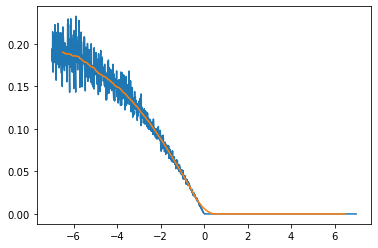

In [21]:
Generated_data_test = Feedback_Generator(5*10**6, Testing_data)
Testing_data = Price_Env_Exp_reward(Generated_data_test)

In [35]:
Reward_record, Exp_Reward_record, Price_record = Run_Experiment(10000, Train_env_hybrid)

Random: conversion rate =0.0295
Random: conversion rate with profit =0.0135
Random: average reward =-0.5792
Random: average expected reward =-0.0168
Random: average expected reward loss =6.0045
Random: over price proportion =0.6490
Random: average over price gap =116.4604
Random: under price proportion =0.3454
Random: average under price gap =36.1007
Random: average difference from optimal =152.5611
Model_based: conversion rate =0.0118
Model_based: conversion rate with profit =0.0072
Model_based: average reward =0.3509
Model_based: average expected reward =0.1891
Model_based: average expected reward loss =5.7986
Model_based: over price proportion =0.9002
Model_based: average over price gap =245.7349
Model_based: under price proportion =0.0928
Model_based: average under price gap =13.6462
Model_based: average difference from optimal =259.3811
Model_based_under_est: conversion rate =0.0165
Model_based_under_est: conversion rate with profit =0.0108
Model_based_under_est: average reward =0

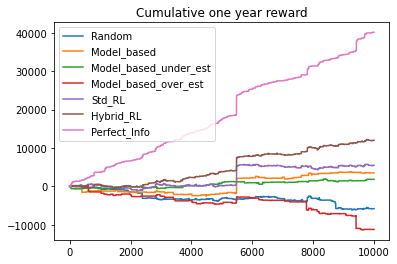

In [36]:
for a in ["Random", "Model_based", "Model_based_under_est", "Model_based_over_est","Std_RL", "Hybrid_RL","Perfect_Info"]:
    Cumsum_Reward = np.cumsum(Reward_record[a])
    plt.plot(np.arange(len(Cumsum_Reward)), Cumsum_Reward, label = a)
plt.title("Cumulative one year reward")
plt.legend()
plt.savefig('cumulative_reward.pdf')

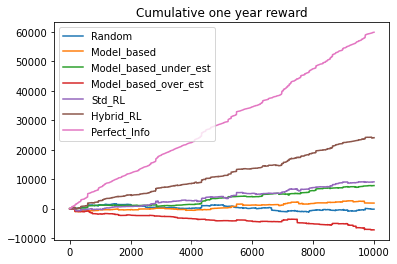

In [37]:
for a in ["Random", "Model_based", "Model_based_under_est", "Model_based_over_est","Std_RL", "Hybrid_RL","Perfect_Info"]:
    Cumsum_Reward = np.cumsum(Exp_Reward_record[a])
    plt.plot(np.arange(len(Cumsum_Reward)), Cumsum_Reward, label = a)
plt.title("Cumulative one year reward")
plt.legend()
plt.savefig('cumulative_exp_reward.pdf')